In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (train_test_split,
                                     GridSearchCV)
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder,
                                   MinMaxScaler)

from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             recall_score,
                             precision_score,
                             f1_score)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from collections import Counter

import warnings
warnings.filterwarnings('ignore')


# Configs:

In [2]:
PATH = '/kaggle/input/loan-defaulter'

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

# Helpers:

In [4]:
def analyze_cat(feature, data):
    print(f"{feature} distribution:\n")
    print(data[feature].value_counts(normalize = True))
    # Create a figure with 2 subplots (1 row, 2 columns)
    fig, axs = plt.subplots(2, 1, figsize=(9, 20))
    sns.countplot(data = data, y = feature, ax= axs[0])
    axs[0].set_title(f'{feature} Distribution')
    axs[0].set_xlabel('Frequency')
    sns.countplot(data = data, y = feature, hue = 'TARGET', ax= axs[1])
    axs[1].set_title(f'{feature} / TARGET Relationship')
    axs[1].set_xlabel('Frequency');
    print()
    print('According to target:\n')
    print(data.groupby(feature)['TARGET'].value_counts(normalize = True))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)  # Increase the spacing between subplots


In [5]:
def analyze_cont(feature, data):
    print(f'{feature} Distribution:\n')
    print(data[feature].describe())
    print('*'*5)
    print("According to target:")
    print(data.groupby('TARGET')[feature].describe())
    print('*'*5)
    fig, axs = plt.subplots(3, 1, figsize=(6, 8))
    sns.distplot(data[feature], ax = axs[0])
    axs[0].set_title(f'Distribution of {feature}')
    
    sns.boxplot(data = data, x = feature, ax = axs[1])
    axs[1].set_title(f'Distribution of {feature}')
    
    sns.boxplot(data = data, x= 'TARGET', y = feature, ax= axs[2])
    axs[2].set_title(f'Distribution of {feature}/ TARGET')
    plt.subplots_adjust(hspace=0.5, wspace=0.5);


# Read Data:

In [6]:
curr_apps = pd.read_csv(os.path.join(PATH, 'application_data.csv'))
prev_apps = pd.read_csv(os.path.join(PATH, 'previous_application.csv'))
print(f'Current applications shape: {curr_apps.shape}')
print(f'Previous applications shape: {prev_apps.shape}')

Current applications shape: (307511, 122)
Previous applications shape: (1670214, 37)


# EDA:
Considering the huge size of data and to keep the notebook as organized as possible, I separated the EDA part into another notebook attached with this. 

In [7]:
X  = curr_apps.drop(columns= ['TARGET'])
y = curr_apps['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
eda_df = pd.concat([X_train, y_train], axis = 1)
eda_df.shape

(246008, 122)

# Data Processing:
After EDA, we don't find much information on the previous applications data, so we decided to drop it to simplify the analysis.
We noticed some issues in the data that affect the data quality so, we will fix them.
We also noticed some features have no contribution to the target value, so we will drop them to avoid adding noise.

* Drop insignificant Columns
* Delete Columns with more than 40 perecnt of missing values.
* Fix data quality issues, like negative values in some columns (DAYS_BIRTH,.. ).
* Features Extraction.
* Features transformation.





In [9]:
# So. this is the list of features that have a potential predictive power, we will use them in our model.
# keep potentially important features 
potential_features = [
    'CODE_GENDER', 
    'NAME_EDUCATION_TYPE', 
    'OCCUPATION_TYPE', 
    'ORGANIZATION_TYPE', 
    'NAME_CONTRACT_TYPE',
    'NAME_INCOME_TYPE',
    'FLAG_EMP_PHONE',
    'REGION_RATING_CLIENT',
    'REGION_RATING_CLIENT_W_CITY', 
    'REG_CITY_NOT_LIVE_CITY', 
    'REG_CITY_NOT_WORK_CITY', 
    'DAYS_BIRTH', 
    'DAYS_ID_PUBLISH',
    'AMT_ANNUITY', 
    'EXT_SOURCE_3', 
    'DAYS_LAST_PHONE_CHANGE', 
    'EXT_SOURCE_2', 
    'DAYS_EMPLOYED', 
    'DAYS_REGISTRATION', 
]

In [10]:
df = eda_df.copy()

In [11]:
def process(data, transform = True):
    """
    data is the features X 
    """
    # keep only selected features
    data = data[potential_features]
    
    # drop cols with > 40% nulls
    null_dist = data.isna().mean() *100
    drop_cols = null_dist[null_dist > 40].index.tolist()
    data = data.drop(columns=drop_cols)
    
    # Fix Negative Values:
    cols_w_neg = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE' ]
    for col in cols_w_neg:
        data[col] = abs(data[col])
        
    # Impute Null Values
    ## In categorical feature : Occupation type, we will fill with 'missing' 
    data['OCCUPATION_TYPE'] = data['OCCUPATION_TYPE'].fillna('missing')
    ## For Numerical features EXT_SOURCE_{2,3} and AMT_ANNUITY, we will use the median as the data is skewed.
    data['EXT_SOURCE_2'] = data['EXT_SOURCE_2'].fillna(data['EXT_SOURCE_2'].median())
    data['EXT_SOURCE_3'] = data['EXT_SOURCE_3'].fillna(data['EXT_SOURCE_3'].median())
    data['AMT_ANNUITY'] = data['AMT_ANNUITY'].fillna(data['AMT_ANNUITY'].median())
    data['DAYS_LAST_PHONE_CHANGE'] = data['DAYS_LAST_PHONE_CHANGE'].fillna(data['DAYS_LAST_PHONE_CHANGE'].median())

    

        
    # Feature Extractions
    ## We convert days into years to avoid huge variation in the range of values.
    data['applicant_age'] = np.ceil(data.DAYS_BIRTH /365)
    data['employment_yrs'] = np.ceil(data.DAYS_EMPLOYED /365)
    data['registeration']=  np.ceil(data.DAYS_REGISTRATION /365)
    data['puplish'] = np.ceil(data.DAYS_ID_PUBLISH / 365)
    data['phone_change'] = np.ceil(data.DAYS_LAST_PHONE_CHANGE /365)
    ## Drop the original Ones.
    data = data.drop(columns = cols_w_neg)
    
    # We apply some transformation for data like encoding and standardization incase the model expect the data transformed in some format.
    ## categorical
    cat_features =  ['CODE_GENDER', 'NAME_EDUCATION_TYPE', 
           'OCCUPATION_TYPE','ORGANIZATION_TYPE', 'NAME_CONTRACT_TYPE', 'NAME_INCOME_TYPE' ]
    num_features = ['AMT_ANNUITY', 'EXT_SOURCE_2','EXT_SOURCE_3', 'applicant_age', 'employment_yrs', 'registeration', 'puplish', 'phone_change']

    encoder = OneHotEncoder(sparse=False, drop='first')
    cat_encoded = encoder.fit_transform(data[cat_features])
    df_encoded = pd.DataFrame(cat_encoded, columns=encoder.get_feature_names_out(cat_features))
    if transform: # Tree models can handle skewed features    
        ## Numerical
        # Or for normalization
        scaler = MinMaxScaler()
        df_scaled = pd.DataFrame(scaler.fit_transform(data[num_features]), columns = num_features)
        
        data = pd.concat([df_encoded, df_scaled], axis = 1)
        return data
    data = pd.concat([df_encoded, data[num_features]])
    return data


    
    
    


# Modeling:

Before Modeling we can decrease the dimensionality of our data, for better training. Two methods can be used to achieve this.
* PCA.
* Feature Selection using RF.

In [12]:
# for base model
X_train_trans = process(X_train, True)
X_test_trans = process(X_test, True)

# for tree models:
X_train_no_trans = process(X_train, True)
X_test_no_trans = process(X_test, True)

In [13]:
X_train_no_trans.shape, X_test_no_trans.shape

((246008, 97), (61503, 97))

**1. PCA:**

In [14]:
pca = PCA(n_components=10)  # Reduce to 2 principal components for example
X_train_pca = pca.fit_transform(X_train_trans)
X_test_pca = pca.transform(X_test_trans)

**2. Random Forest Feature Selection:**

In [ ]:
rf_selection = RandomForestClassifier(n_estimators=50,
                               criterion="gini",
                               max_depth=5,
                               min_samples_split=10,
                               bootstrap=True,
                               max_samples=0.8,
                               oob_score=True,
                               class_weight = "balanced",
                               n_jobs=-1,
                               random_state=0)
rf_selection.fit(X_train_no_trans, y_train)
importance = pd.DataFrame(rf_selection.feature_importances_, index = X_train_no_trans.columns, columns = ["importance"]).sort_values("importance", ascending  = False)
importance.plot(kind='barh', title="Feature Importance", figsize = (5, 20))
plt.show()

In [ ]:
importance.sort_values(by = 'importance', ascending = False)

,importance
EXT_SOURCE_2,0.315255
EXT_SOURCE_3,0.237471
employment_yrs,0.085698
applicant_age,0.048728
NAME_EDUCATION_TYPE_Secondary / secondary special,0.041917
CODE_GENDER_M,0.031493
NAME_INCOME_TYPE_Working,0.028073
NAME_EDUCATION_TYPE_Higher education,0.027239
phone_change,0.027138
puplish,0.025912


In [ ]:
# Important Features according to RF are EXT_DOCS {2 and 3} as shown in our analysis (EDA part). We will keep some 
rf_features = importance.iloc[:16].index.to_list()
rf_features

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'employment_yrs',
 'applicant_age',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'CODE_GENDER_M',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Higher education',
 'phone_change',
 'puplish',
 'NAME_INCOME_TYPE_Pensioner',
 'registeration',
 'AMT_ANNUITY',
 'ORGANIZATION_TYPE_XNA',
 'NAME_CONTRACT_TYPE_Revolving loans',
 'OCCUPATION_TYPE_Laborers']

**1. Logistic Regression:**

We will treat logistic regression as our base model, to see the influence of our models on business KPIs.

class_report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.00      0.00      0.00      4949

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



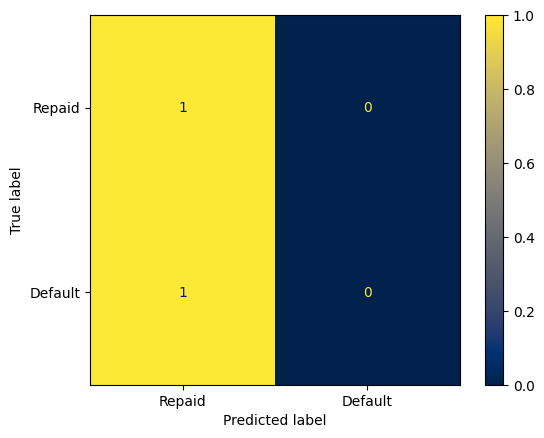

In [ ]:
# Using PCA features:
log_reg = LogisticRegression()
log_reg.fit(X_train_pca, y_train)

# Predict on the test set
y_pred_log_1 = log_reg.predict(X_test_pca)
# Evaluate the model using a confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred_log_1)
class_report = classification_report(y_test, y_pred_log_1)
print('class_report:\n', class_report)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log_1,
                                                    cmap = "cividis",
                                                    normalize = 'true',
                                                    display_labels = ("Repaid", "Default")
                                                  )


In [27]:
# Calculate precision and recall
precision = precision_score(y_test, y_pred_log_1)
recall = recall_score(y_test, y_pred_log_1)
print('precision: ', precision)
print('Recall: ', recall)

precision:  0.0
Recall:  0.0


class_report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.38      0.00      0.01      4949

    accuracy                           0.92     61503
   macro avg       0.65      0.50      0.48     61503
weighted avg       0.88      0.92      0.88     61503



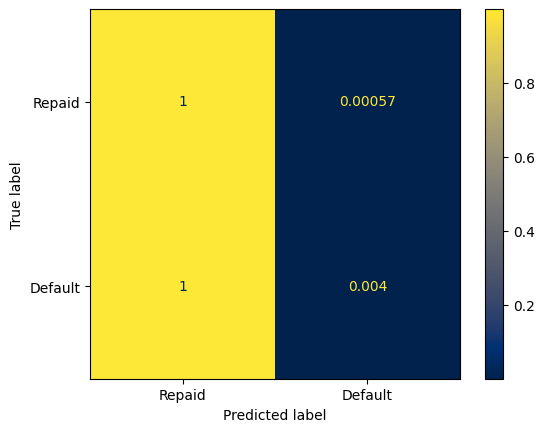

In [19]:
# Using PCA features:
log_reg = LogisticRegression()
log_reg.fit(X_train_no_trans[rf_features], y_train)

# Predict on the test set
y_pred_log_2 = log_reg.predict(X_test_no_trans[rf_features])
# Evaluate the model using a confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred_log_2)
class_report = classification_report(y_test, y_pred_log_2)
print('class_report:\n', class_report)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log_2,
                                                    cmap = "cividis",
                                                    normalize = 'true',
                                                    display_labels = ("Repaid", "Default")
                                                  )

In [28]:
# Calculate precision and recall
precision = precision_score(y_test, y_pred_log_2)
recall = recall_score(y_test, y_pred_log_2)
print('precision: ', precision)
print('Recall: ', recall)

precision:  0.38461538461538464
Recall:  0.00404122044857547


**We see the performance of the model is very poor, we think of using more powerful learning method.**

**2. Decision Trees:**

class_report:
               precision    recall  f1-score   support

           0       0.95      0.62      0.75     56554
           1       0.12      0.60      0.20      4949

    accuracy                           0.62     61503
   macro avg       0.53      0.61      0.48     61503
weighted avg       0.88      0.62      0.70     61503



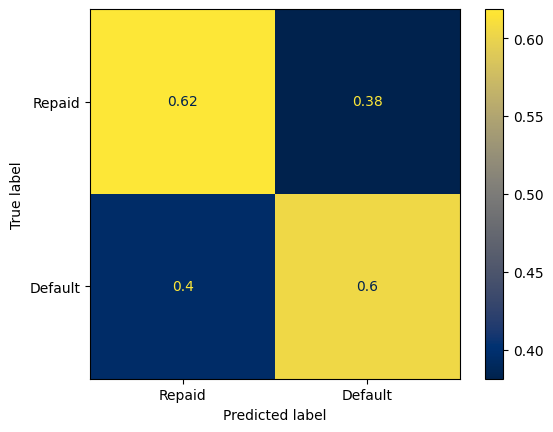

In [20]:
# Train a decision tree classifier
decision_tree = DecisionTreeClassifier(max_depth= 10, class_weight = 'balanced')
decision_tree.fit(X_train_pca, y_train)

# Predict on the test set
y_pred_tree1 = decision_tree.predict(X_test_pca)

# Evaluate the model using a confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred_tree1)
class_report = classification_report(y_test, y_pred_tree1)

print('class_report:\n', class_report)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tree1,
                                                    cmap = "cividis",
                                                    normalize = 'true',
                                                    display_labels = ("Repaid", "Default")
                                                  )

In [29]:
# Calculate precision and recall
precision = precision_score(y_test, y_pred_tree1)
recall = recall_score(y_test, y_pred_tree1)
print('precision: ', precision)
print('Recall: ', recall)

precision:  0.12188963551211567
Recall:  0.6047686401293191


class_report:
               precision    recall  f1-score   support

           0       0.95      0.70      0.81     56554
           1       0.14      0.58      0.23      4949

    accuracy                           0.69     61503
   macro avg       0.55      0.64      0.52     61503
weighted avg       0.88      0.69      0.76     61503



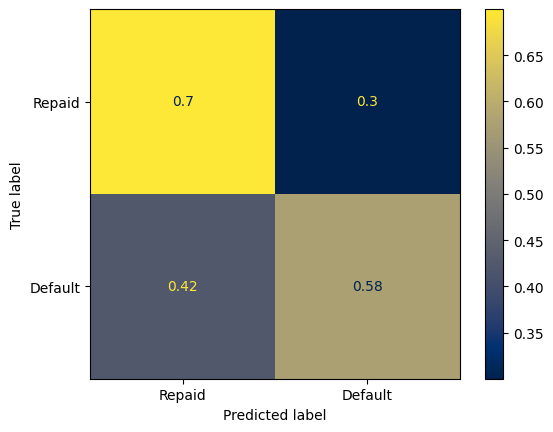

In [21]:
# Train a decision tree classifier
decision_tree2 = DecisionTreeClassifier(max_depth= 10, class_weight = 'balanced')
decision_tree2.fit(X_train_trans[rf_features], y_train)

# Predict on the test set
y_pred_tree2 = decision_tree2.predict(X_test_trans[rf_features])

# Evaluate the model using a confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred_tree2)
class_report = classification_report(y_test, y_pred_tree2)

print('class_report:\n', class_report)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tree2,
                                                    cmap = "cividis",
                                                    normalize = 'true',
                                                    display_labels = ("Repaid", "Default")
                                                  )

**As we see, the performance of decision tree is better than simple logistic regression. Now, we can make use of more advanced methods (Ensemble models) like bagging and boosting mechanism to get better performance.**

**A. Bagging Method: Random Forest:**

Confusion Matrix:
[[36211 20343]
 [ 1880  3069]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.64      0.77     56554
           1       0.13      0.62      0.22      4949

    accuracy                           0.64     61503
   macro avg       0.54      0.63      0.49     61503
weighted avg       0.88      0.64      0.72     61503



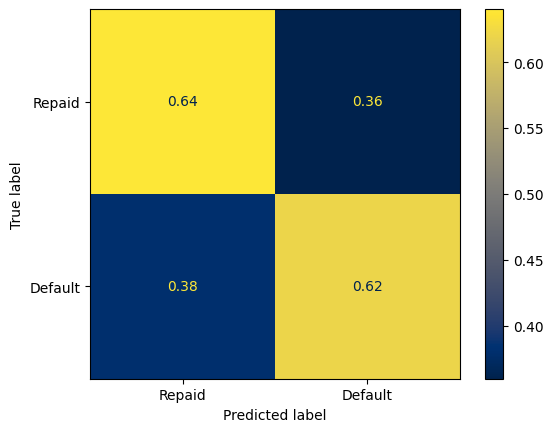

In [22]:
# Train a Random Forest classifier on features extracted using PCA
random_forest = RandomForestClassifier(n_estimators=500, random_state=42,
                               criterion="gini",
                               max_depth=7,
                               min_samples_split=10,
                               bootstrap=True,
                               max_samples=0.6,
                               oob_score=True,
                               class_weight = "balanced",
                               n_jobs=-1)
random_forest.fit(X_train_pca, y_train)

# Predict on the test set
y_pred_forest = random_forest.predict(X_test_pca)

# Evaluate the model using a confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred_forest)
class_report = classification_report(y_test, y_pred_forest)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_forest,
                                                    cmap = "cividis",
                                                    normalize = 'true',
                                                    display_labels = ("Repaid", "Default")
                                                  )

Confusion Matrix:
[[43280 13274]
 [ 2148  2801]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.77      0.85     56554
           1       0.17      0.57      0.27      4949

    accuracy                           0.75     61503
   macro avg       0.56      0.67      0.56     61503
weighted avg       0.89      0.75      0.80     61503



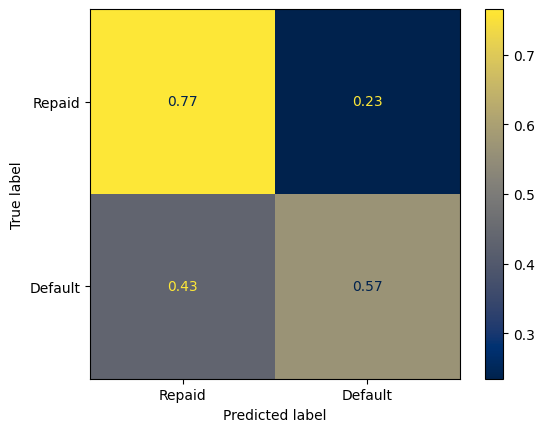

In [23]:
# Train a Random Forest classifier
random_forest2 = RandomForestClassifier(n_estimators=500, random_state=42,
                               criterion="gini",
                               max_depth=10,
                               min_samples_split=10,
                               bootstrap=True,
                               max_samples=0.7,
                               oob_score=True,
                               class_weight = "balanced",
                               n_jobs=-1)
random_forest2.fit(X_train_trans[rf_features], y_train)

# Predict on the test set
y_pred_forest = random_forest2.predict(X_test_trans[rf_features])

# Evaluate the model using a confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred_forest)
class_report = classification_report(y_test, y_pred_forest)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_forest,
                                                    cmap = "cividis",
                                                    normalize = 'true',
                                                    display_labels = ("Repaid", "Default")
                                                  )

**B. Boosting method: XGBoost:**


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.80      0.87     56554
           1       0.15      0.40      0.22      4949

    accuracy                           0.77     61503
   macro avg       0.55      0.60      0.54     61503
weighted avg       0.88      0.77      0.82     61503



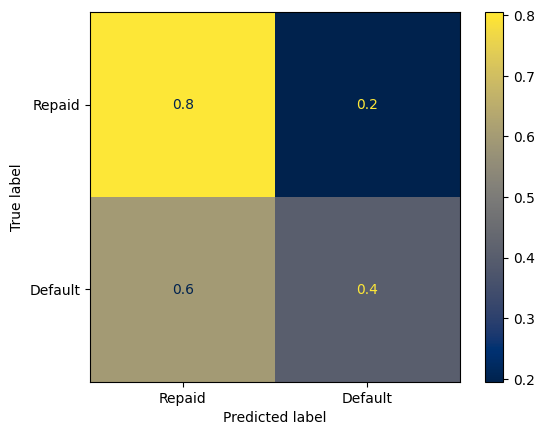

In [24]:
# Train an XGBoost classifier
params = dict(
    base_score = 0.5, booster = 'gbtree', colsample_bylevel = 1,
    colsample_bynode = 1, colsample_bytree = 1, gamma = 0,
    importance_type = 'gain', interaction_constraints = '',
    learning_rate = 0.3, max_delta_step = 0, max_depth = 6,
    min_child_weight = 1, missing = np.nan, monotone_constraints = '()',
    n_estimators = 500, n_jobs = -1, num_parallel_tree = 1,
    random_state = 42, reg_alpha = 0,
    reg_lambda = 1, scale_pos_weight = 10, subsample = 1,
    tree_method = 'exact', use_label_encoder = False,
    validate_parameters = 1, verbosity = None
)
xgb_classifier = XGBClassifier(**params)
xgb_classifier.fit(X_train_pca, y_train)

# Predict on the test set
y_pred_xgb = xgb_classifier.predict(X_test_pca)

# Evaluate the model using a confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
class_report = classification_report(y_test, y_pred_xgb)

print("\nClassification Report:")
print(class_report)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb,
                                                    cmap = "cividis",
                                                    normalize = 'true',
                                                    display_labels = ("Repaid", "Default")
                                                  )


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.82      0.88     56554
           1       0.17      0.42      0.24      4949

    accuracy                           0.79     61503
   macro avg       0.56      0.62      0.56     61503
weighted avg       0.88      0.79      0.83     61503



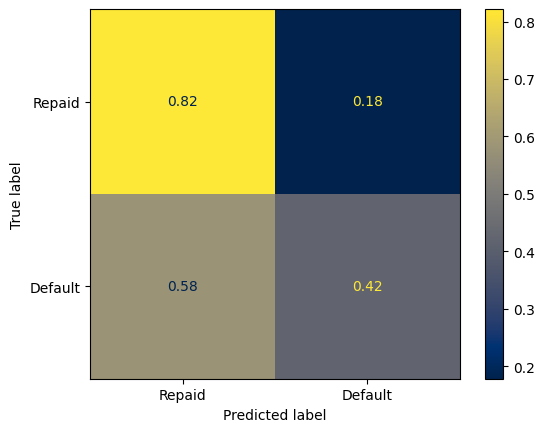

In [25]:
# Train an XGBoost classifier
# Define the parameters for the model
params = dict(
    base_score = 0.5, booster = 'gbtree', colsample_bylevel = 1,
    colsample_bynode = 1, colsample_bytree = 1, gamma = 0,
    importance_type = 'gain', interaction_constraints = '',
    learning_rate = 0.3, max_delta_step = 0, max_depth = 6,
    min_child_weight = 1, missing = np.nan, monotone_constraints = '()',
    n_estimators = 500, n_jobs = -1, num_parallel_tree = 1,
    random_state = 42, reg_alpha = 0,
    reg_lambda = 1, scale_pos_weight = 10, subsample = 1,
    tree_method = 'exact', use_label_encoder = False,
    validate_parameters = 1, verbosity = None
)
xgb_classifier2 = XGBClassifier(**params)
xgb_classifier2.fit(X_train_trans[rf_features], y_train)

# Predict on the test set
y_pred_xgb = xgb_classifier2.predict(X_test_trans[rf_features])

# Evaluate the model using a confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
class_report = classification_report(y_test, y_pred_xgb)
print("\nClassification Report:")
print(class_report)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb,
                                                    cmap = "cividis",
                                                    normalize = 'true',
                                                    display_labels = ("Repaid", "Default")
                                                  )

**Through different trials with hyperparameters, I see these model can achieve a higher performance. I could automate this search by using grid search or any other technique, but I wanted to keep it simple and avoid wasting more time.**

# Business KPIs:

**We analyse the performance of these models according to our business KPIs. There can be various KPIs for risk analysis; in this study, we focus more on:**

* **Default rate**: We need to decrease the rate of default by being able to predict these applications.

* **Approval rate**: We need to increase the approval rate for clients who will repay.

**In this scenario, I choose decreasing the default rate to be more critical.**


# Evaluation:
We will evaluate the model using precision, recall, and F1 score.
* The highest f1 score didn't exceed 27% was obtained by random forest model trained on features extracted by another random forest model.
* Random forest model trained on PCA components achieved the highest recall 62%, which is more suitable for default rate KPI.
* XGboost achieved the highest precision across all versions (15% and 17%), which can be good for the acceptance rate KPI.
* Despite the low metrics, these models show an advance in performance against our base model (logistic regression in our case).
